In [12]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import feature
from skimage.color import rgb2gray
from tqdm import tqdm

In [46]:
# 定义一个函数，遍历指定路径，收集图片信息
def collect_images_info(root_dir):
    data = []
    for main_class in os.listdir(root_dir):
        main_class_path = os.path.join(root_dir, main_class)
        if os.path.isdir(main_class_path):
            
#             for sub_class in os.listdir(main_class_path):
#                 sub_class_path = os.path.join(main_class_path, sub_class)
#                 if os.path.isdir(sub_class_path):
            
            for img_name in os.listdir(main_class_path):
                if img_name.endswith('.png'):
                    img_path = os.path.join(main_class_path, img_name)
#                             label = f"{sub_class}"
                    label = f"{main_class}"
                    data.append((img_name, img_path, label))
    return data

# 定义一个函数，将图片转换为NumPy数组
def image_to_array(img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = img.resize((72,72))
    img_array = np.array(img)
    return img_array

# 收集图片信息
root_dir = './dataset'  # 更改为你的图片根目录
images_info = collect_images_info(root_dir)

# 创建DataFrame
df = pd.DataFrame(images_info, columns=['ImageName', 'ImagePath', 'Label'])

tqdm.pandas(desc="Progress")

# 假设 image_to_array 是一个自定义函数，用于将图像路径转换为数组
df['ImageArray'] = df['ImagePath'].progress_apply(image_to_array)


# # 将图片转换为NumPy数组并添加到DataFrame中
# df['ImageArray'] = df['ImagePath'].apply(image_to_array)

# 移除不再需要的ImagePath列
df.drop('ImagePath', axis=1, inplace=True)
df.drop('ImageName', axis=1, inplace=True)

# 对标签进行编码
label_encoder = LabelEncoder()
df['EncodedLabel'] = label_encoder.fit_transform(df['Label'])

df.head()

Progress:   9%|████▋                                             | 151/1616 [00:00<00:00, 1509.20it/s]/Users/liukm/anaconda3/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Progress: 100%|██████████████████████████████████████████████████| 1616/1616 [00:01<00:00, 946.98it/s]


,Label,ImageArray,EncodedLabel
0,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21
1,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21
2,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21
3,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21
4,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21


(36, 36, 3)


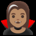

In [19]:
# for i in range(1616):
#     if df['ImageArray'][i].ndim == 3
print(df['ImageArray'][0].shape)
Image.fromarray(df['ImageArray'][0])

In [47]:
def preprocess_image(image_array):
    # 将图像数据转换为numpy数组
    img_array = np.array(image_array)

    # 颜色空间转换 - RGB到灰度
    gray_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

    # 边缘检测 - 使用Canny边缘检测器
    edges = cv2.Canny(gray_img, 100, 200)

    return edges

df['ImageEdge'] = df['ImageArray'].apply(lambda x: preprocess_image(x))
df.head()

,Label,ImageArray,EncodedLabel,ImageEdge
0,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [48]:
def extract_color_histogram(image_array, bins=32):
    histogram = [cv2.calcHist([image_array], [i], None, [bins], [0, 256]) for i in range(3)]
    histogram = np.concatenate(histogram)
    histogram = cv2.normalize(histogram, histogram).flatten()
    return histogram

def extract_lbp_features(image_array, P=8, R=1):
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    lbp = feature.local_binary_pattern(gray_image, P, R, 'uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_sift_features(image_array):
    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return []
    return descriptors



# 应用特征提取方法到DataFrame上
# 注意：这里示例代码假设ImageArray中存储的是适合处理的图像数据
df['ColorHistogram'] = df['ImageArray'].apply(lambda x: extract_color_histogram(x))
df['LBPFeatures'] = df['ImageArray'].apply(lambda x: extract_lbp_features(x))
df['SIFTFeatures'] = df['ImageArray'].apply(lambda x: extract_sift_features(x)) # 需要环境支持

# 由于特征提取可能会产生不同长度的数组，你可能需要进一步处理这些特征，以适应你的机器学习模型
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616 entries, 0 to 1615
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Label           1616 non-null   object
 1   ImageArray      1616 non-null   object
 2   EncodedLabel    1616 non-null   int64 
 3   ImageEdge       1616 non-null   object
 4   ColorHistogram  1616 non-null   object
 5   LBPFeatures     1616 non-null   object
 6   SIFTFeatures    1616 non-null   object
dtypes: int64(1), object(6)
memory usage: 88.5+ KB
None


,Label,ImageArray,EncodedLabel,ImageEdge,ColorHistogram,LBPFeatures,SIFTFeatures
0,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.44985324, 0.00097055716, 0.0021837535, 0.00...","[0.004050925925847783, 0.01678240740708367, 0....","[[4.0, 115.0, 115.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.44775826, 0.0, 0.0, 0.0004552702, 0.0437059...","[0.008680555555388107, 0.018325617283597113, 0...","[[5.0, 146.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1..."
2,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.4276936, 0.0, 0.0, 0.0, 0.040651582, 0.0107...","[0.010609567901029909, 0.02411265432052252, 0....","[[5.0, 148.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.44945174, 0.0, 0.0, 0.0004569921, 0.0438712...","[0.008487654320823927, 0.019290123456418014, 0...","[[4.0, 148.0, 81.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7..."
4,vampire,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.45515814, 0.0009820025, 0.0022095055, 0.002...","[0.0048225308641045034, 0.018325617283597113, ...","[[3.0, 138.0, 104.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


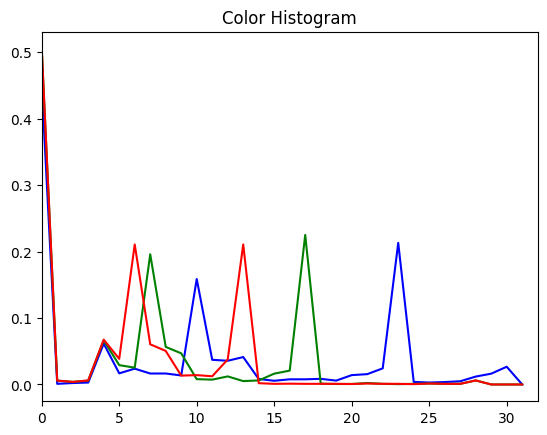

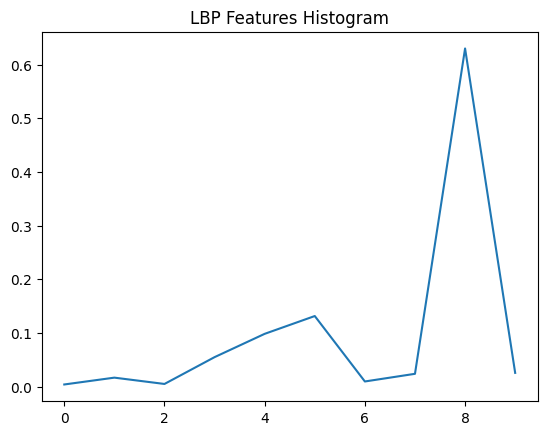

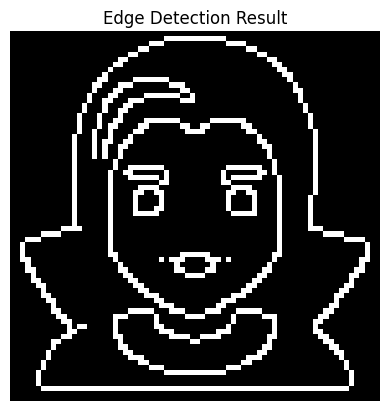

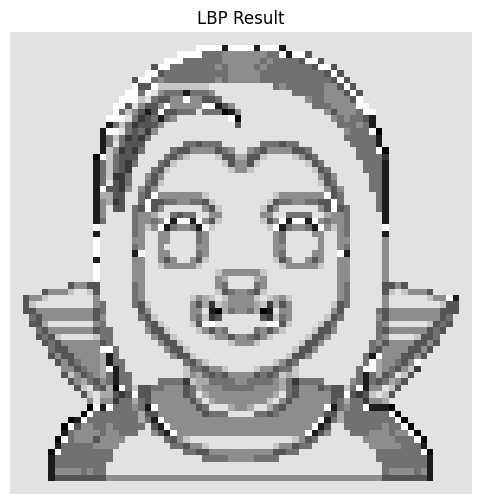

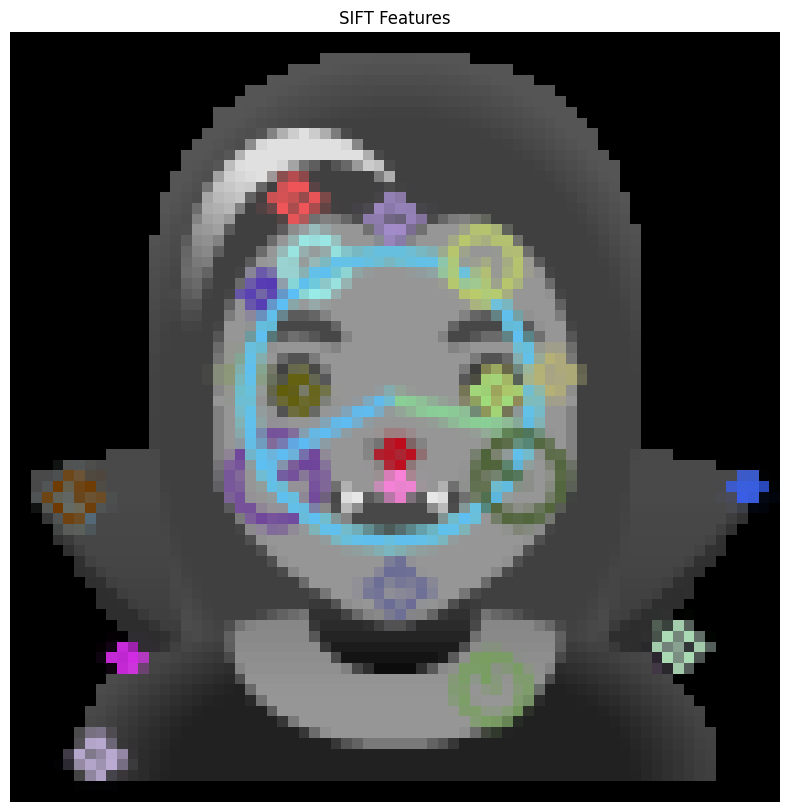

In [49]:
import matplotlib.pyplot as plt

def plot_color_histogram(color_histogram):
    color = ('b', 'g', 'r')
    for i, col in enumerate(color):
        plt.plot(color_histogram[i * 32:(i + 1) * 32], color=col)
        plt.xlim([0, 32])
    plt.title('Color Histogram')
    plt.show()

# 假设你已经提取了某个图像的颜色直方图并存储在ColorHistogram列中
# 选择第一个图像的颜色直方图进行可视化
plot_color_histogram(df['ColorHistogram'].iloc[0])

def plot_lbp_features(lbp_features):
    plt.plot(lbp_features)
    plt.title('LBP Features Histogram')
    plt.show()

# 假设你已经提取了某个图像的LBP特征并存储在LBPFeatures列中
# 选择第一个图像的LBP特征进行可视化
plot_lbp_features(df['LBPFeatures'].iloc[0])

def plot_edge_detection(image_edges):
    plt.imshow(image_edges, cmap='gray')
    plt.title('Edge Detection Result')
    plt.axis('off') # 不显示坐标轴
    plt.show()

plot_edge_detection(df['ImageEdge'].iloc[0])

def show_lbp_image(image_array):
    # 首先将图像转换为灰度图，因为LBP通常在灰度图上计算
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    # 计算LBP特征
    lbp = feature.local_binary_pattern(gray_image, P=8, R=1, method="uniform")
    # 将LBP特征图标准化到0-255范围内以便可视化
    lbp_image = (lbp - lbp.min()) / (lbp.max() - lbp.min()) * 255
    lbp_image = lbp_image.astype("uint8")

    # 显示LBP图像
    plt.figure(figsize=(6, 6))
    plt.imshow(lbp_image, cmap='gray')
    plt.title('LBP Result')
    plt.axis('off')  # 不显示坐标轴
    plt.show()

# 使用示例
# 假设your_image_array是你想要处理的图像数组
show_lbp_image(df['ImageArray'].iloc[0])

def visualize_sift_features(image_array):
    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    sift_image = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(sift_image, cmap='gray')
    plt.title('SIFT Features')
    plt.axis('off')
    plt.show()

visualize_sift_features(df['ImageArray'].iloc[0])

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Label           1154 non-null   object
 1   ImageArray      1154 non-null   object
 2   EncodedLabel    1154 non-null   int64 
 3   ImageEdge       1154 non-null   object
 4   ColorHistogram  1154 non-null   object
 5   LBPFeatures     1154 non-null   object
 6   SIFTFeatures    1154 non-null   object
dtypes: int64(1), object(6)
memory usage: 63.2+ KB


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

X = np.array(df['ImageArray'].apply(lambda x: np.array(x).flatten()))
X = np.array([np.array(xi) for xi in X])
y = np.array(df['EncodedLabel'])

# 归一化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 降维处理
pca = PCA(n_components=32)  # 假设我们想要降到2维
X_pca = pca.fit_transform(X_scaled)


# 数据拆分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# 现在你有了归一化、降维后的训练集和测试集，可以用于模型训练和评估

In [51]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# train an SVM model.
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# predict on the validation set.
y_pred = svm.predict(X_test)

# calculate accuracy.
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 99.38%


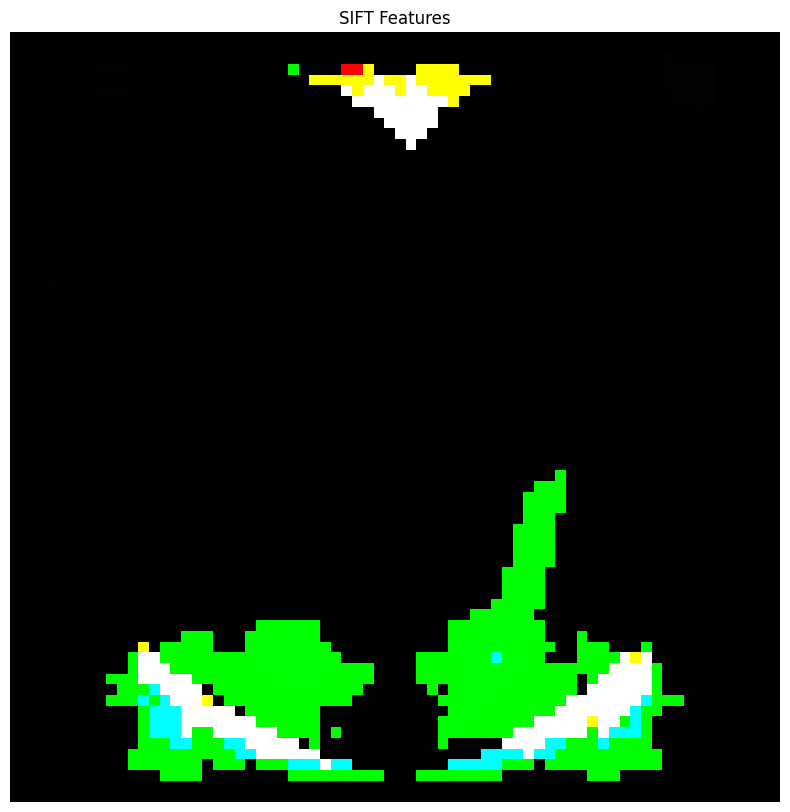

Sample index: 77, Actual label: 7, Predicted label: 13


In [55]:

misclassified_indexes = np.where(y_test != y_pred)[0]
# 假设 misclassified_indexes 是我们之前找到的
for index in misclassified_indexes:
    # 从X_test取出对应的展开的图像数据
    image_data = X_test[index]
    # 将展开的数组还原回原始形状
    image_data_reshaped = image_data.reshape(72, 72, 3)
    # 使用PIL将数组转换为图像
    image = Image.fromarray(np.uint8(image_data_reshaped))
    # 显示图像
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title('SIFT Features')
    plt.axis('off')
    plt.show()
    print(f'Sample index: {index}, Actual label: {y_test[index]}, Predicted label: {y_pred[index]}')


In [38]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# predict on the validation set.
predictions = model.predict(X_test)

# calculate accuracy.
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 91.98%


In [39]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

# 进行分类预测
predictions = model.predict(X_test)

# calculate accuracy.
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 96.91%


In [40]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

# 进行分类预测
predictions = model.predict(X_test)

# calculate accuracy.
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 96.91%


/Users/liukm/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [28]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

# 进行分类预测
predictions = model.predict(X_test)

# calculate accuracy.
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

KeyboardInterrupt: 

In [92]:
from PIL import Image, ImageEnhance
import numpy as np

def augment_image(image_array, rotation_degree=30, brightness_factor=1.2):
    """
    对图像进行数据增强（旋转和亮度调整）
    :param image_array: 输入图像的numpy数组
    :param rotation_degree: 旋转角度
    :param brightness_factor: 亮度调整因子
    :return: 增强后的图像的numpy数组
    """
    # 将numpy数组转换为PIL图像
    image = Image.fromarray(image_array)
    
    # 旋转图像
    rotated_image = image.rotate(rotation_degree)
    
    # 调整亮度
    enhancer = ImageEnhance.Brightness(rotated_image)
    brightened_image = enhancer.enhance(brightness_factor)
    
    # 将PIL图像转换回numpy数组
    augmented_image_array = np.array(rotated_image)
    
    return augmented_image_array

augmented_df = pd.DataFrame(columns=['Label', 'ImageArray', 'EncodedLabel'])

for index, row in df.iterrows():
    # 获取原始图像数组
    original_image_array = row['ImageArray']
    
    # 应用数据增强
    augmented_image_array = augment_image(original_image_array, 60, 1.2)
    augmented_image_array = augment_image(original_image_array, 120, 1.2)
    augmented_image_array = augment_image(original_image_array, 180, 1.2)
    augmented_image_array = augment_image(original_image_array, 240, 1.2)
    augmented_image_array = augment_image(original_image_array, 300, 1.2)
    # 构建新的DataFrame行
    new_row = {'Label': row['Label'], 'ImageArray': augmented_image_array, 'EncodedLabel': row['EncodedLabel']}
    
    # 将新行添加到增强后的DataFrame中
    augmented_df = augmented_df.append(new_row, ignore_index=True)

# 现在augmented_df包含了原始图像及增强后的图像，你可以选择将其与原始df合并
df_combined = pd.concat([df, augmented_df], ignore_index=True)
df.info()

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Label         1154 non-null   object
 1   ImageArray    1154 non-null   object
 2   EncodedLabel  1154 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 27.2+ KB


/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)
/var/folders/l8/s9p_6rvj4y97cq9qnzl8c6xr0000gn/T/ipykernel_77596/3816977536.py:43: FutureWarning: The frame.append method is deprecated and will be removed f